In [1]:
import sqlalchemy as sqla
import sys
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale, normalize

# Connect to DB

In [2]:
# Chose the DB
db_input_2021 = input ("What database should we use?\n\n")

# Create the sqlalchemy engine
db_engine_2021 = sqla.create_engine(db_input_2021) 

# Test connection
try:
    db_connection = db_engine_2021.connect()
except Exception as exc:
    print("\nCouldn't connect to the database\n")
    try:
        print(exc.message, exc.args)
    except:
        pass
    sys.exit()
        
# If everything goes well, just be happy about it!
    print("\nHooray! We connected to the database!")

In [3]:
# Chose the DB
db_input_2020 = input ("What database should we use?\n\n") 

# Create the sqlalchemy engine
db_engine_2020 = sqla.create_engine(db_input_2020)

# Test connection
try:
    db_connection = db_engine_2020.connect()
except Exception as exc:
    print("\nCouldn't connect to the database\n")
    try:
        print(exc.message, exc.args)
    except:
        pass
    sys.exit()
        
# If everything goes well, just be happy about it!
    print("\nHooray! We connected to the database!")

# - Input data -

## Scraping for EGID, GBAUP, GBAUJ, GKLAS, GKAT

In [3]:
# List of EGIDs from merged_egid_intersect: we have SATOM measurements for it

egid_df = pd.read_sql_query("SELECT DISTINCT EGID FROM city.merged_egid_intersect", db_engine_2021).dropna()
niter = egid_df.shape[0]

#Initiating storage for the scrapping results: empty Dataframe with default values
data = {"EGID": np.repeat(0,niter), "GBAUP": np.repeat(0,niter), "GBAUJ": np.repeat(0,niter),"GKLAS": np.repeat(0,niter), "GKAT": np.repeat(0,niter), "E": np.repeat(0,niter), "N": np.repeat(0,niter), "gastw": np.repeat(0,niter)}
data_df = pd.DataFrame(data)

In [ ]:
GEOADMIN_BASE_URL = "https://api.geo.admin.ch/rest/services/ech/MapServer/ch.bfs.gebaeude_wohnungs_register/"

# Scraping to get EGID, GBAUP, GBAUJ, GKALS, GKAT, gastw (number floors)

for i in range(niter): 

    EGID = egid_df.iloc[i];
    print("Setting building", EGID) 
 
    url = GEOADMIN_BASE_URL + str(int(EGID.values[0])) + "_0"
    response = requests.get(url=url)
    print(response)

    # scrapping blocked by map.geo.admin.ch
    if response.status_code != 200:
        print("Scrapping blocked by map.geo.admin.ch")
    
    else:
        regbl = response.json()
        
        
    
    # Collecting data during scraping 
    data_df.iloc[i,0] = int(EGID)
    
    if regbl["feature"]["attributes"]["gbaup"] is None:
        data_df.iloc[i,1] = np.nan
    else:
        data_df.iloc[i,1] = int(regbl["feature"]["attributes"]["gbaup"])
    
    if regbl["feature"]["attributes"]["gbauj"] is None:
        data_df.iloc[i,2] = np.nan
    else:
        data_df.iloc[i,2] = int(regbl["feature"]["attributes"]["gbauj"])
        
    if regbl["feature"]["attributes"]["gklas"] is None:
        data_df.iloc[i,3] = np.nan
    else:
        data_df.iloc[i,3] = int(regbl["feature"]["attributes"]["gklas"])
    
    if regbl["feature"]["attributes"]["gkat"] is None:
        data_df.iloc[i,4] = np.nan
    else:
        data_df.iloc[i,4] = int(regbl["feature"]["attributes"]["gkat"])
        
    if regbl["feature"]["attributes"]["gastw"] is None:
        data_df.iloc[i,7] = np.nan
    else:
        data_df.iloc[i,7] = int(regbl["feature"]["attributes"]["gastw"])
    

    data_df.iloc[i,5] = float(regbl["feature"]["geometry"]["x"])
    data_df.iloc[i,6] = float(regbl["feature"]["geometry"]["y"])

In [4]:
"""Using locally saved daata instead of scraping each time"""

"""Saving for future use. Uncomment to save table to computer"""
#data_df.to_csv('data_df')

""" Instead of scraping each time, can open csv form computer again"""
#data_path = 'data_df' #Make sure the data_df has been saved to the current working directory
#data_df = pd.read_csv(data_path)

In [5]:
 data_df

,Unnamed: 0,EGID,GBAUP,GBAUJ,GKLAS,GKAT,E,N,gastw
0,0,926301,8016.0,NaN,1110.0,1020,562159.0,120478.1,2.0
1,1,191637939,8017.0,1990.0,1110.0,1020,563134.4,119462.3,2.0
2,2,9014600,8017.0,NaN,1122.0,1020,562668.0,121802.1,4.0
3,3,9014527,NaN,NaN,1251.0,1060,563827.0,121588.1,NaN
4,4,190019246,8020.0,2004.0,1110.0,1020,560746.0,122518.2,2.0
...,...,...,...,...,...,...,...,...,...
3386,3386,190013443,8020.0,2003.0,1110.0,1020,560883.1,125043.1,3.0
3387,3387,924454,8014.0,NaN,1121.0,1020,561962.5,124252.8,3.0
3388,3388,3110391,8019.0,NaN,1110.0,1020,560904.0,124913.1,2.0
3389,3389,926016,8017.0,NaN,1110.0,1020,562285.0,121700.1,3.0


## Geometry

In [6]:
envelope = gpd.read_postgis(
        "SELECT surf.geometry AS geometry, thema.objectclass_id AS class_id, REGBL.egid AS egid, surf.cityobject_id AS cityobject_id, construction.constr_id as composite_id " #keep space before quote
        "FROM city.regbl_data REGBL "
        #"FROM citydb.cross_reference cros "
        "LEFT JOIN citydb.cross_reference cros ON cros.egid = REGBL.egid " #remove if doing whole area building_root_id [egid] satom (root_id)
        "JOIN citydb.building build ON build.building_root_id = cros.building_root_id " # [building_root_id] egid satom root_id (building_id objectclass_id building_parent_id)
        #"JOIN citydb.building build ON build.building_root_id = cros.building_root_id AND cros.egid = 190056978 "
        "LEFT JOIN citydb.thematic_surface thema ON thema.building_id = build.id " # building_root_id egid satom root_id [building_id] objectclass_id building_parent_id (thematic_surface_id objeclass_id building_id lod2_multisurface_id)
        "LEFT JOIN citydb.building_installation install ON install.building_id = build.id " # building_root_id egid satom root_id [building_id] objectclass_id building_parent_id thematic_surface_id objeclass_id building_id lod2_multisurface_id (thema.objectclass_id lod2_brep_id)
        "JOIN citydb.surface_geometry surf ON (surf.root_id = thema.lod2_multi_surface_id OR surf.root_id = install.lod2_brep_id) AND surf.geometry IS NOT NULL " # OR surf.root_id = install.lod2_brep_id OR zone.root_id = surf.root_id #remove OR shade.root_id = surf.root_id if doing without shading surfaces
        # building_root_id egid satom root_id building_id objectclass_id building_parent_id thematic_surface_id objeclass_id building_id [lod2_multisurface_id] thema.objectclass_id [lod2_brep_id] (geometry parent_id)
        #"LEFT JOIN city.regbl_data rbl ON rbl.egid = cros.egid "  # building_root_id [egid] satom root_id building_id objectclass_id building_parent_id thematic_surface_id objeclass_id building_id lod2_multisurface_id thema.objectclass_id lod2_brep_id geometry parent_id (construction_period)
        "LEFT JOIN citydb.nrg8_cityobj_to_constr construction ON surf.cityobject_id = construction.cityobject_id",
        #"LEFT JOIN surfaces_data.default_composites comp ON comp.class_id = thema.objectclass_id AND rbl.construction_year BETWEEN comp.period_start AND comp.period_end",
        db_engine_2021, geom_col='geometry')



envelope = envelope.dropna(subset=['composite_id'])
envelope = envelope.dropna(subset=['geometry'])
envelope = envelope.drop_duplicates(subset=['geometry'])
envelope = envelope.drop(["composite_id"], axis=1)


#Keep floors objid =35
envelope = envelope[envelope["class_id"]==35]
envelope_merge_final_energy = envelope

envelope["geometry_area"] = envelope["geometry"].area

# Keep areas for result normalisation by surface
floor_areas = envelope.groupby(['egid']).sum()
floor_areas_final = floor_areas.drop(['class_id', 'cityobject_id'], axis = 1)
floor_areas_final = floor_areas_final.rename(columns={'geometry_area': "surface"})
floor_areas_final

,surface
egid,
923868,110.230510
923874,113.495075
923909,109.844431
923912,18.353558
923913,48.491940
...,...
191649872,32.174796
191652312,28.804608
191696052,19.171948


# Collecting the climate data in order to implement climate inputs

In [7]:
meteo_path = 'Aigle_MeteoSchweiz_2019_v2.cli'
# Take the climate file and remove the header
# keep only columns woth data
meteo_df = pd.read_csv(meteo_path, delimiter=' ')
meteo_df = meteo_df.drop(["FF", "DD", "RH", "N"], axis=1)

In [8]:
meteo_df_average = meteo_df.drop(["dm", "m", "h", "RR"], axis=1)
G_Dh_mean = meteo_df_average["G_Dh"].mean()
G_h_mean = meteo_df_average["G_h"].mean()
Ta_mean = meteo_df_average["Ta"].mean()
Ts_mean = meteo_df_average["Ts"].mean()
precipitation_sum = meteo_df["RR"].sum()
G_Dh_mean


59.6745079908673

In [9]:
vol_df = pd.merge(floor_areas, data_df, left_on="egid", right_on="EGID",how="left")
vol_df["volume"] = np.multiply(vol_df["geometry_area"],vol_df["gastw"]*4) # Assume that each floor is 4m
vol_df

,class_id,cityobject_id,geometry_area,Unnamed: 0,EGID,GBAUP,GBAUJ,GKLAS,GKAT,E,N,gastw,volume
0,175.0,193390,110.230510,1134.0,923868.0,8012.0,NaN,1110.0,1020.0,560789.8,127748.5,2.0,881.844080
1,2450.0,2632490,113.495075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70.0,73758,109.844431,1194.0,923909.0,8015.0,NaN,1110.0,1020.0,561157.8,127489.8,3.0,1318.133166
3,105.0,87018,18.353558,3328.0,923912.0,8013.0,NaN,1110.0,1030.0,561256.0,127250.7,1.0,73.414232
4,70.0,62902,48.491940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,350.0,549982,32.174796,1038.0,191649872.0,8012.0,1919.0,1110.0,1020.0,562088.4,122254.3,3.0,386.097558
552,105.0,169635,28.804608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,175.0,330875,19.171948,7.0,191696052.0,8023.0,2019.0,1122.0,1020.0,562044.4,122260.3,5.0,383.438960
554,175.0,267900,41.655406,2370.0,191761197.0,8019.0,1999.0,1110.0,1030.0,562180.0,122455.1,3.0,499.864866


In [10]:
# Calculating building volume

vol_df = pd.merge(floor_areas, data_df, left_on="egid", right_on="EGID",how="left")
#vol_df = pd.merge(vol_df_temp, floor_areas_final, left_on = "EGID", right_on="egid", how="inner")
vol_df = vol_df.dropna(subset=["EGID", "GBAUP", "GKLAS", "GKAT", "gastw"])
vol_df["volume"] = np.multiply(vol_df["geometry_area"],vol_df["gastw"]*4) # Assume that each floor is 4m
vol_df['G_Dh'] = pd.Series([G_Dh_mean for x in range(600)])## a corriger car ne fonctionnait pas super bien
vol_df['G_h'] = pd.Series([G_h_mean for x in range(600)])
vol_df['Ta'] = pd.Series([Ta_mean for x in range(600)])
vol_df['Ts'] = pd.Series([Ts_mean for x in range(600)])
vol_df['RR'] = pd.Series([precipitation_sum for x in range(600)])
vol_df = vol_df.rename(columns={'geometry_area': "surface"})
input_df = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUP", "GBAUJ", "GKLAS", "GKAT", "G_Dh","G_h","Ta","Ts","RR"], axis=1)
input_df2 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUP", "GBAUJ", "GKAT","G_Dh","G_h","Ta","Ts","RR"], axis=1)
input_df3 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUP", "GBAUJ","G_Dh","G_h","Ta","Ts","RR"], axis=1)
input_df4 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUJ","G_Dh","G_h","Ta","Ts","RR"], axis=1)
input_df5 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUJ", "GKAT", "GKLAS","G_Dh","G_h","Ta","Ts","RR"], axis=1)
input_df6 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUJ", "volume","G_Dh","G_h","Ta","Ts","RR"], axis=1)
input_df7 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUP", "GBAUJ", "GKLAS", "GKAT", "G_Dh","volume","Ta","Ts","RR"], axis=1)
input_df8 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUP", "GBAUJ", "GKLAS", "GKAT", "G_Dh","volume","Ts","RR"], axis=1)
input_df9 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUP", "GBAUJ", "GKLAS", "GKAT", "G_Dh","volume","Ts"], axis=1)
input_df10 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUP", "GBAUJ", "GKLAS", "GKAT", "G_Dh","Ts"], axis=1)
input_df11 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUJ", "G_Dh","Ts"], axis=1)
input_df12 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUJ","GKAT", "G_Dh","G_h","Ta","Ts","RR"], axis=1)
input_df13 = vol_df.drop(["Unnamed: 0", "E", "N", "gastw", "class_id", "cityobject_id",  "GBAUJ","GKAT", "G_Dh","Ts"], axis=1)





In [11]:
vol_df.dropna()


,class_id,cityobject_id,surface,Unnamed: 0,EGID,GBAUP,GBAUJ,GKLAS,GKAT,E,N,gastw,volume,G_Dh,G_h,Ta,Ts,RR
118,175.0,139525,114.345264,1874.0,924770.0,8018.0,1992.0,1251.0,1040.0,561823.0,125700.2,2.0,914.762112,59.674508,159.607076,11.045255,12.660589,1015.1
370,2415.0,2313984,54.698462,2518.0,9038031.0,8017.0,1989.0,1251.0,1040.0,561601.0,126164.1,2.0,437.587700,59.674508,159.607076,11.045255,12.660589,1015.1
377,175.0,316228,250.052772,1693.0,9038070.0,8017.0,1989.0,1263.0,1060.0,562278.1,124577.4,2.0,2000.422176,59.674508,159.607076,11.045255,12.660589,1015.1
383,70.0,147482,117.009104,2349.0,90004908.0,8012.0,1919.0,1110.0,1020.0,561948.1,124394.7,2.0,936.072832,59.674508,159.607076,11.045255,12.660589,1015.1
385,70.0,119330,33.944284,1129.0,101165865.0,8020.0,2002.0,1110.0,1020.0,562382.9,124874.8,1.0,135.777134,59.674508,159.607076,11.045255,12.660589,1015.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,210.0,336564,123.992696,1227.0,191579561.0,8023.0,2017.0,1122.0,1020.0,562641.4,122215.3,6.0,2975.824692,59.674508,159.607076,11.045255,12.660589,1015.1
545,105.0,205455,40.287417,1808.0,191621572.0,8016.0,1985.0,1110.0,1030.0,562070.3,122726.3,2.0,322.299332,59.674508,159.607076,11.045255,12.660589,1015.1
551,350.0,549982,32.174796,1038.0,191649872.0,8012.0,1919.0,1110.0,1020.0,562088.4,122254.3,3.0,386.097558,59.674508,159.607076,11.045255,12.660589,1015.1
553,175.0,330875,19.171948,7.0,191696052.0,8023.0,2019.0,1122.0,1020.0,562044.4,122260.3,5.0,383.438960,59.674508,159.607076,11.045255,12.660589,1015.1


## Correlation 

In [12]:
# standardise features: adapt to model
X = pd.DataFrame(scale(input_df13.drop(["EGID", "surface"], axis = 1)))
X.columns = ["volume", "GKLAS", "GBAUP", "G_h", "Ta", "RR"]
X

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


,volume,GKLAS,GBAUP,G_h,Ta,RR
0,-1.238419,-0.369855,-0.212232,0.0,0.0,0.0
1,-0.344291,-0.369855,-0.078317,0.0,0.0,0.0
2,-0.940376,-0.369855,-0.460373,0.0,0.0,0.0
3,-0.344291,0.024053,0.463391,0.0,0.0,0.0
4,-1.536461,0.024053,-0.127683,0.0,0.0,0.0
...,...,...,...,...,...,...
343,2.040051,0.024053,0.430496,0.0,0.0,0.0
344,-0.046248,-0.369855,-0.383980,0.0,0.0,0.0
345,-1.238419,-0.369855,-0.364397,0.0,0.0,0.0
346,2.040051,0.024053,-0.365213,0.0,0.0,0.0


<AxesSubplot:>

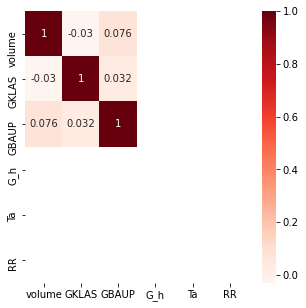

In [13]:
plt.figure(figsize = (5, 5))
cor = X.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)

#  - Output data -

## 2019 cumulative demand measured by SATOM

In [13]:
# Download output for training (results of SATOM measurements)
"""
satom_df = pd.read_sql_query("SELECT gmlid, values_array FROM citydb.nrg8_time_series WHERE time_interval_unit='year'", db_engine_2021)
satom_df['values_array'] = satom_df['values_array'].apply(pd.Series)
merged_egid_intersect = pd.read_sql_query("SELECT gmlid, egid FROM city.merged_egid_intersect", db_engine_2021)
db_connection.close()

output_df = pd.merge(satom_df, merged_egid_intersect, on="gmlid", how="right").dropna().drop_duplicates(["egid"])
output_df = output_df[output_df["annual_energy"] !=0]

#contains gmlid, annual energy cons, egid

"""

'\nsatom_df = pd.read_sql_query("SELECT gmlid, values_array FROM citydb.nrg8_time_series WHERE time_interval_unit=\'year\'", db_engine_2021)\nsatom_df[\'values_array\'] = satom_df[\'values_array\'].apply(pd.Series)\nmerged_egid_intersect = pd.read_sql_query("SELECT gmlid, egid FROM city.merged_egid_intersect", db_engine_2021)\ndb_connection.close()\n\noutput_df = pd.merge(satom_df, merged_egid_intersect, on="gmlid", how="right").dropna().drop_duplicates(["egid"])\noutput_df\n#contains gmlid, annual energy cons, egid\n\n'

In [11]:
"""Using locally saved data"""

output_df = pd.read_csv("yearly.csv", index_col=False).drop_duplicates(["ogr_fid"])
output_df = output_df[["annual_energy", "gmlid", "ogr_fid", "egid"]]
output_df = output_df.dropna()
output_df = output_df.drop_duplicates(["egid"])

In [12]:
output_df = output_df[output_df["annual_energy"] !=0]

# - Linking input & output data -

In [13]:
#Select the model by changing the input_df for the merge

input_output_df = pd.merge(input_df13, output_df, left_on="EGID", right_on="egid", how="inner")
input_output_df.head(5)

,surface,EGID,GBAUP,GKLAS,volume,G_h,Ta,RR,annual_energy,gmlid,ogr_fid,egid
0,96.557143,925140.0,8012.0,1122.0,1158.685716,159.607076,11.045255,1015.1,160963.0,_23A25652-1CD9-4457-AE1E-A53A07D06CA5,921.0,925140.0
1,83.105961,925148.0,8016.0,1122.0,1994.543052,159.607076,11.045255,1015.1,251120.0,_AE0F7597-0F55-429D-82ED-0E74A3EE5FC1,904.0,925148.0
2,60.614135,925196.0,8013.0,1121.0,727.369620,159.607076,11.045255,1015.1,433539.0,_4215DBFF-93D9-44F6-9CED-C534ED975C98,784.0,925196.0
3,76.565648,925210.0,8013.0,1122.0,2756.363328,159.607076,11.045255,1015.1,331283.0,UUID_3e006c16-cc80-40de-a7bf-8ae2b45d6ef0,990.0,925210.0
4,154.219087,925229.0,8014.0,1122.0,3701.258076,159.607076,11.045255,1015.1,4549590.0,UUID_0a5fa891-110f-436b-864f-7f0741855bdf,787.0,925229.0


# - Linear model - 

## Split in train & test

In [14]:
# Adapt the columns selected in X depending on the model

X = input_output_df[["EGID", "volume", "GKLAS","GBAUP", "surface",'G_h', "Ta", 'RR']] #to adapt to model
y = pd.DataFrame(input_output_df["annual_energy"])
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2)

In [15]:
# preparing the final dataframe containing egid, satom energy and predicted energy values
data_energy_prediction = {"EGID": [], "Satom_energy": [], "predicted_energy": [], "surface":[]}
energy_prediction = pd.DataFrame(data_energy_prediction)
energy_prediction['EGID'] = x_te['EGID'] 
energy_prediction['surface'] = x_te['surface']
energy_prediction['Satom_energy'] = y_te.astype(int)
to_append = pd.DataFrame()
to_append['EGID'] = x_tr['EGID']
to_append['Satom_energy'] = y_tr.astype(int)
to_append['predicted_energy'] = y_tr.astype(int)
to_append['surface'] = x_tr['surface']
energy_prediction = energy_prediction.append(to_append, ignore_index=True)
x_tr = x_tr.drop(["EGID", "surface"], axis = 1)
x_te = x_te.drop(["EGID", "surface"], axis = 1)


In [16]:
energy_prediction

,EGID,Satom_energy,predicted_energy,surface
0,190176833.0,180091,NaN,263.985158
1,925450.0,657598,NaN,78.227170
2,925416.0,105325,NaN,112.201497
3,3110418.0,446181,NaN,267.483506
4,191579561.0,492538,NaN,123.992696
5,925557.0,829597,NaN,19.355511
6,925596.0,53101,NaN,7.620698
7,9038070.0,1739733,1739733.0,250.052772
8,925148.0,251120,251120.0,83.105961
9,9014514.0,5619730,5619730.0,69.340221


## Train

In [17]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regr = regressor.fit(x_tr,y_tr)

print(regr.intercept_)
print(regr.coef_)

# Predictions
y_pred = regr.predict(x_te)
#y_pred = pd.DataFrame(y_pred)

# Copying the predicted energies in the final dataframe
energy_prediction.iloc[0:len(x_te),2] = y_pred.astype(int)
energy_prediction['difference_of_energy'] = np.abs(energy_prediction['predicted_energy'].sub(energy_prediction['Satom_energy'], axis = 0))
energy_prediction['surface_energy']= energy_prediction["difference_of_energy"]/energy_prediction["surface"]
energy_prediction['normalised_prediction']= energy_prediction["predicted_energy"]/energy_prediction["surface"]
energy_prediction


[6.28647593e+08]
[[ 2.28427650e+00  7.63093829e+02 -7.83960489e+04  0.00000000e+00
   0.00000000e+00  1.91430315e-24]]


,EGID,Satom_energy,predicted_energy,surface,difference_of_energy,surface_energy,normalised_prediction
0,190176833.0,180091,703548.0,263.985158,523457.0,1982.903145,2665.104377
1,925450.0,657598,1163741.0,78.227170,506143.0,6470.168868,14876.429762
2,925416.0,105325,1007786.0,112.201497,902461.0,8043.217106,8981.930072
3,3110418.0,446181,841599.0,267.483506,395418.0,1478.289285,3146.358496
4,191579561.0,492538,539081.0,123.992696,46543.0,375.368886,4347.683529
5,925557.0,829597,1160337.0,19.355511,330740.0,17087.639792,59948.662676
6,925596.0,53101,1385623.0,7.620698,1332522.0,174855.636592,181823.633487
7,9038070.0,1739733,1739733.0,250.052772,0.0,0.000000,6957.463363
8,925148.0,251120,251120.0,83.105961,0.0,0.000000,3021.684588
9,9014514.0,5619730,5619730.0,69.340221,0.0,0.000000,81045.746882


In [18]:
energy_prediction['tag'] = pd.DataFrame(np.repeat('test', len(x_te)))
energy_prediction = energy_prediction.fillna('train')

In [19]:
energy_prediction

,EGID,Satom_energy,predicted_energy,surface,difference_of_energy,surface_energy,normalised_prediction,tag
0,190176833.0,180091,703548.0,263.985158,523457.0,1982.903145,2665.104377,test
1,925450.0,657598,1163741.0,78.227170,506143.0,6470.168868,14876.429762,test
2,925416.0,105325,1007786.0,112.201497,902461.0,8043.217106,8981.930072,test
3,3110418.0,446181,841599.0,267.483506,395418.0,1478.289285,3146.358496,test
4,191579561.0,492538,539081.0,123.992696,46543.0,375.368886,4347.683529,test
5,925557.0,829597,1160337.0,19.355511,330740.0,17087.639792,59948.662676,test
6,925596.0,53101,1385623.0,7.620698,1332522.0,174855.636592,181823.633487,test
7,9038070.0,1739733,1739733.0,250.052772,0.0,0.000000,6957.463363,train
8,925148.0,251120,251120.0,83.105961,0.0,0.000000,3021.684588,train
9,9014514.0,5619730,5619730.0,69.340221,0.0,0.000000,81045.746882,train


In [20]:
mean_surface_calculation = energy_prediction[energy_prediction['tag']=='test']
mean_surface_calculation

mean_surface = mean_surface_calculation['surface'].mean()
mean_surface

124.69517642924518

## Results

In [21]:
# Metrics
# not normalised
mse = mean_squared_error(y_te, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_te, y_pred)
#normalised
mse_norm = mean_squared_error(y_te, y_pred)/mean_surface
rmse_norm = np.sqrt(mse_norm)

print("Performance of the model: \n Mean Squared Error:" +str(mse)+ "\n Root Mean Squared Error:" +str(rmse)+ 
     "\n R2:" +str(r_squared) )
print("Performance of the model: \n Mean Squared Error normalised:" +str(mse_norm)+ "\n Root Mean Squared Error normalised:" +str(rmse_norm))
      #+"\n Mean Abs Percentage Error:" +str(mape))


Performance of the model: 
 Mean Squared Error:484021770061.5748
 Root Mean Squared Error:695716.7311927857
 R2:-5.554021446087394
Performance of the model: 
 Mean Squared Error normalised:3881639883.1290765
 Root Mean Squared Error normalised:62302.80798751431


In [22]:
energy_prediction.head(50)

,EGID,Satom_energy,predicted_energy,surface,difference_of_energy,surface_energy,normalised_prediction,tag
0,190176833.0,180091,703548.0,263.985158,523457.0,1982.903145,2665.104377,test
1,925450.0,657598,1163741.0,78.227170,506143.0,6470.168868,14876.429762,test
2,925416.0,105325,1007786.0,112.201497,902461.0,8043.217106,8981.930072,test
3,3110418.0,446181,841599.0,267.483506,395418.0,1478.289285,3146.358496,test
4,191579561.0,492538,539081.0,123.992696,46543.0,375.368886,4347.683529,test
5,925557.0,829597,1160337.0,19.355511,330740.0,17087.639792,59948.662676,test
6,925596.0,53101,1385623.0,7.620698,1332522.0,174855.636592,181823.633487,test
7,9038070.0,1739733,1739733.0,250.052772,0.0,0.000000,6957.463363,train
8,925148.0,251120,251120.0,83.105961,0.0,0.000000,3021.684588,train
9,9014514.0,5619730,5619730.0,69.340221,0.0,0.000000,81045.746882,train


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Energie annuelle mesurée SATOM [kWh]')

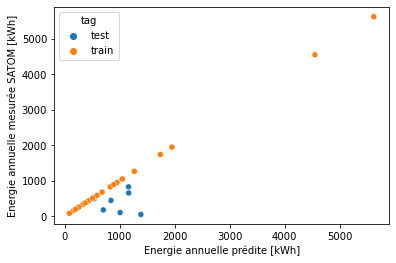

In [31]:
# Convert in kWh: *0.001
a = energy_prediction['predicted_energy']*0.001
b = energy_prediction['Satom_energy']*0.001

sns.scatterplot(a, b, hue=energy_prediction['tag'])
plt.xlabel("Energie annuelle prédite [kWh]")
plt.ylabel("Energie annuelle mesurée SATOM [kWh]")
#set_xlim([0,2000000])
#plt.xlim([0,2000000])

# Dataframe for plotting the Satom energy and predicted energy

In [26]:
"""Save results by uncommenting corresponding row"""

#df_energy_prediction = energy_prediction 
#df_energy_prediction2 = energy_prediction 
#df_energy_prediction3 = energy_prediction 
#df_energy_prediction4 = energy_prediction 
#df_energy_prediction5 = energy_prediction 
#df_energy_prediction6 = energy_prediction 
#df_energy_prediction7 = energy_prediction 
#df_energy_prediction8 = energy_prediction 
#df_energy_prediction9 = energy_prediction 
#df_energy_prediction10 = energy_prediction 
#df_energy_prediction11 = energy_prediction 
#df_energy_prediction12 = energy_prediction 
#df_energy_prediction13 = energy_prediction 

In [ ]:
#Merging with the envelope to obtain the geometry of the building (only the floor as we want to plot in 2D)

df_energy_prediction_final = envelope_merge_final_energy.merge(df_energy_prediction, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final = df_energy_prediction_final.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final2 = envelope_merge_final_energy.merge(df_energy_prediction2, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final2 = df_energy_prediction_final2.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final3 = envelope_merge_final_energy.merge(df_energy_prediction3, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final3 = df_energy_prediction_final3.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final4 = envelope_merge_final_energy.merge(df_energy_prediction4, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final4 = df_energy_prediction_final4.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final5 = envelope_merge_final_energy.merge(df_energy_prediction5, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final5 = df_energy_prediction_final5.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final6 = envelope_merge_final_energy.merge(df_energy_prediction6, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final6 = df_energy_prediction_final6.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

"""
df_energy_prediction_final7 = envelope_merge_final_energy.merge(df_energy_prediction7, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final7 = df_energy_prediction_final7.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final8 = envelope_merge_final_energy.merge(df_energy_prediction8, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final8 = df_energy_prediction_final8.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final9 = envelope_merge_final_energy.merge(df_energy_prediction9, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final9 = df_energy_prediction_final9.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)
"""
df_energy_prediction_final10 = envelope_merge_final_energy.merge(df_energy_prediction10, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final10 = df_energy_prediction_final10.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final11 = envelope_merge_final_energy.merge(df_energy_prediction11, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final11 = df_energy_prediction_final11.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final12 = envelope_merge_final_energy.merge(df_energy_prediction12, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final12 = df_energy_prediction_final12.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_energy_prediction_final13 = envelope_merge_final_energy.merge(df_energy_prediction13, left_on="egid", right_on="EGID",how="inner")
df_energy_prediction_final13 = df_energy_prediction_final13.drop(["class_id","cityobject_id","geometry_area","egid"], axis = 1)

df_test = envelope_merge_final_energy.merge(input_output_df, left_on="egid", right_on="EGID",how="inner")
df_test = df_test.drop(["class_id","cityobject_id","geometry_area","egid_x", "egid_y","volume","gmlid"], axis = 1)

In [ ]:
df_energy_prediction_final13

# Plotting the results

In [ ]:
import rasterio
import rasterio.plot

countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
raster = rasterio.open("NE1_50M_SR_W/SI25-2012-2013-2014.tif") 

fig, ax = plt.subplots(figsize=(20, 20))
rasterio.plot.show(raster, ax=ax)
df_energy_prediction_final.plot(column="predicted_energy",legend=True, ax=ax, legend_kwds={"label": "kWh"})
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
df_energy_prediction_final13.plot(ax=ax,column="difference_of_energy",legend=True, legend_kwds={"label": "kWh"})
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
plt.show()